<a id="1"></a>
# <p style="background-color:#23a118;font-family:georgia,serif;color:#FFF8ED;font-size:150%;text-align:center;border-radius:10px 10px;">Predicting Optimal Fertilizers</p>

---
# Introduction:
This is an interesting competition indeed, with an interesting evaluation metric.
Here is a quick explaination of the metric we have at hand.

### Explaining MAP@3:

Let:

* $N$ be the total number of test observations (rows).
* $K = 3$ be the maximum number of predictions allowed per observation.
* For the $i$-th observation:

  * You submit a ranked list of up to $K$ fertilizer names:

    $$
      \bigl[\hat{y}_{i}^{(1)},\,\hat{y}_{i}^{(2)},\,\hat{y}_{i}^{(3)}\bigr].
    $$
  * The ground-truth (single) fertilizer is denoted $y_i$.

Define the indicator (relevance) function:

$$
  \mathrm{rel}_i(k) \;=\; 
  \begin{cases}
    1, & \text{if } \hat{y}_{i}^{(k)} = y_i,\\
    0, & \text{otherwise}.
  \end{cases}
$$

That is, $\mathrm{rel}_i(k)$ equals 1 if the $k$-th prediction for observation $i$ matches the true fertilizer; otherwise, it is 0.

The precision at cutoff $k$ for observation $i$ is:

$$
  P_i(k) \;=\; \frac{\displaystyle \sum_{j=1}^{k} \mathrm{rel}_i(j)}{k}.
$$

* Note that $\sum_{j=1}^{k} \mathrm{rel}_i(j)$ is 1 if the correct label appears anywhere in the top $k$, otherwise 0.
* If the correct label first appears at position $k$, then $P_i(k) = \tfrac{1}{k}.$
* If the correct label does not appear in the top $k$, then $P_i(k) = 0.$

The **Average Precision** for a single observation $i$ is:

$$
  \mathrm{AP}_i \;=\; \sum_{k=1}^{K} \bigl[P_i(k)\,\times\,\mathrm{rel}_i(k)\bigr].
$$

Since $\mathrm{rel}_i(k)$ is zero except at the rank where the correct label first appears, $\mathrm{AP}_i$ collapses to:

$$
  \mathrm{AP}_i = 
  \begin{cases}
    1, & \text{if the correct label is at rank }1,\\[6pt]
    \dfrac{1}{2}, & \text{if the correct label is at rank }2,\\[6pt]
    \dfrac{1}{3}, & \text{if the correct label is at rank }3,\\[6pt]
    0, & \text{if the correct label does not appear in top 3.}
  \end{cases}
$$

Finally, the **Mean Average Precision at 3** (MAP\@3) over all observations is:

$$
  \mathrm{MAP@3} 
  \;=\; 
  \frac{1}{N}\;\sum_{i=1}^{N}\; \mathrm{AP}_i 
  \;=\; 
  \frac{1}{N}\;\sum_{i=1}^{N}\;\sum_{k=1}^{3}\Bigl[P_i(k)\,\mathrm{rel}_i(k)\Bigr].
$$

* $N$ = total number of test rows.
* $K = 3.$
* $\hat{y}_{i}^{(k)}$ = the $k$-th predicted fertilizer for row $i$.
* $y_i$ = the single true fertilizer for row $i$.
* $\mathrm{rel}_i(k)$ = indicator of whether $\hat{y}_{i}^{(k)} = y_i$.
* $P_i(k) = \dfrac{\sum_{j=1}^k \mathrm{rel}_i(j)}{k}.$
* $\mathrm{AP}_i = \sum_{k=1}^3 P_i(k)\,\mathrm{rel}_i(k).$
* $\mathrm{MAP@3} = \dfrac{1}{N}\sum_{i=1}^N \mathrm{AP}_i.$

---

*Now let's get to know the Data!*

<a id="1"></a>
# <p style="background-color:#23a118;font-family:georgia,serif;color:#FFF8ED;font-size:120%;text-align:center;border-radius:10px 10px;">EDA </p>

In [1]:
# imports data reading
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns
import xgboost as xgb
import lightgbm as lgb
from tqdm import tqdm
from itertools import combinations
import os
import gc
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.simplefilter('ignore')
palette = ["yellowgreen", "palegreen", "forestgreen", "olive", "darkkhaki"]

In [2]:
train = pd.read_csv("/kaggle/input/playground-series-s5e6/train.csv")
original = pd.read_csv("/kaggle/input/fertilizer-prediction/Fertilizer Prediction.csv")
test = pd.read_csv("/kaggle/input/playground-series-s5e6/test.csv")
sample_sub = pd.read_csv("/kaggle/input/playground-series-s5e6/sample_submission.csv")

In [3]:
train.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous,Fertilizer Name
0,0,37,70,36,Clayey,Sugarcane,36,4,5,28-28
1,1,27,69,65,Sandy,Millets,30,6,18,28-28
2,2,29,63,32,Sandy,Millets,24,12,16,17-17-17
3,3,35,62,54,Sandy,Barley,39,12,4,10-26-26
4,4,35,58,43,Red,Paddy,37,2,16,DAP


In [4]:
print(train.head())

   id  Temparature  Humidity  Moisture Soil Type  Crop Type  Nitrogen  \
0   0           37        70        36    Clayey  Sugarcane        36   
1   1           27        69        65     Sandy    Millets        30   
2   2           29        63        32     Sandy    Millets        24   
3   3           35        62        54     Sandy     Barley        39   
4   4           35        58        43       Red      Paddy        37   

   Potassium  Phosphorous Fertilizer Name  
0          4            5           28-28  
1          6           18           28-28  
2         12           16        17-17-17  
3         12            4        10-26-26  
4          2           16             DAP  


In [5]:
test.head()

,id,Temparature,Humidity,Moisture,Soil Type,Crop Type,Nitrogen,Potassium,Phosphorous
0,750000,31,70,52,Sandy,Wheat,34,11,24
1,750001,27,62,45,Red,Sugarcane,30,14,15
2,750002,28,72,28,Clayey,Ground Nuts,14,15,4
3,750003,37,53,57,Black,Ground Nuts,18,17,36
4,750004,31,55,32,Red,Pulses,13,19,14


In [6]:
train.info()
print("=" * 25)
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 750000 entries, 0 to 749999
Data columns (total 10 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   id               750000 non-null  int64 
 1   Temparature      750000 non-null  int64 
 2   Humidity         750000 non-null  int64 
 3   Moisture         750000 non-null  int64 
 4   Soil Type        750000 non-null  object
 5   Crop Type        750000 non-null  object
 6   Nitrogen         750000 non-null  int64 
 7   Potassium        750000 non-null  int64 
 8   Phosphorous      750000 non-null  int64 
 9   Fertilizer Name  750000 non-null  object
dtypes: int64(7), object(3)
memory usage: 57.2+ MB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   id           250000 non-null  int64 
 1   Temparature  250000 non-null  int64 
 2   Hum

In [7]:
train_unq = train.nunique()
test_unq = test.nunique()
print("Number of unique values for Train:","\n",
      train_unq,"\n", "=" * 25,"\n", "Number of unique values for Test:","\n",
      test_unq)

Number of unique values for Train: 
 id                 750000
Temparature            14
Humidity               23
Moisture               41
Soil Type               5
Crop Type              11
Nitrogen               39
Potassium              20
Phosphorous            43
Fertilizer Name         7
dtype: int64 
 Number of unique values for Test: 
 id             250000
Temparature        14
Humidity           23
Moisture           41
Soil Type           5
Crop Type          11
Nitrogen           39
Potassium          20
Phosphorous        43
dtype: int64


In [8]:
ferts = train["Fertilizer Name"].unique()
crops = train["Crop Type"].unique()
print(f"Ferilizers Uniques: {ferts}","\n" *2, f"Crops Uniques: {crops}")

Ferilizers Uniques: ['28-28' '17-17-17' '10-26-26' 'DAP' '20-20' '14-35-14' 'Urea'] 

 Crops Uniques: ['Sugarcane' 'Millets' 'Barley' 'Paddy' 'Pulses' 'Tobacco' 'Ground Nuts'
 'Maize' 'Cotton' 'Wheat' 'Oil seeds']


In [9]:
train.describe()

,id,Temparature,Humidity,Moisture,Nitrogen,Potassium,Phosphorous
count,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000,750000.000000
mean,374999.500000,31.503565,61.038912,45.184147,23.093808,9.478296,21.073227
std,216506.495284,4.025574,6.647695,11.794594,11.216125,5.765622,12.346831
min,0.000000,25.000000,50.000000,25.000000,4.000000,0.000000,0.000000
25%,187499.750000,28.000000,55.000000,35.000000,13.000000,4.000000,10.000000
50%,374999.500000,32.000000,61.000000,45.000000,23.000000,9.000000,21.000000
75%,562499.250000,35.000000,67.000000,55.000000,33.000000,14.000000,32.000000
max,749999.000000,38.000000,72.000000,65.000000,42.000000,19.000000,42.000000


---

#### Notes:
* No missing values.
* Low Cardinality.
* No outliers.
* The Test data are distributed similar to the train data.
  
The data seems relatively perfect.., which is weird.

---

In [10]:
train = pd.concat([train, original], ignore_index=True)

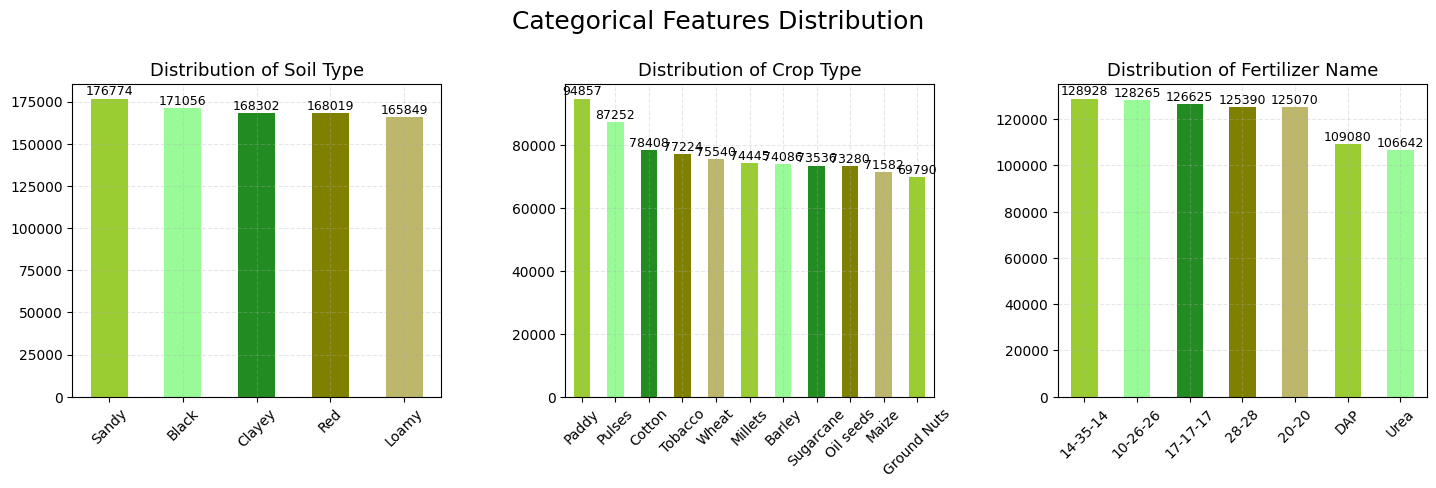

In [11]:
categorical_cols = train.select_dtypes(include=['object', 'category']).columns

# Set up subplot grid
n_cols = 3
n_rows = (len(categorical_cols) + n_cols - 1) // n_cols  # Ceiling division
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
axes = axes.flatten()  # Convert to 1D array for easy iteration

max_bars = 15

for i, col in enumerate(categorical_cols):
    
    value_counts = train[col].value_counts()
    
    if len(value_counts) > max_bars:
        value_counts = value_counts.head(max_bars)
    

    value_counts.plot(kind='bar', ax=axes[i], color=palette)
    axes[i].set_title(f'Distribution of {col}', fontsize=13)
    axes[i].set_xlabel('')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(alpha=0.3, linestyle='--')
    
    # Add count labels on bars
    for p in axes[i].patches:
        axes[i].annotate(f'{int(p.get_height())}', 
                        (p.get_x() + p.get_width() / 2., p.get_height()), 
                        ha='center', va='center', 
                        xytext=(0, 5), 
                        textcoords='offset points',
                        fontsize=9)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=3.0)
plt.suptitle('Categorical Features Distribution', fontsize=18, y=1.02)
plt.show()

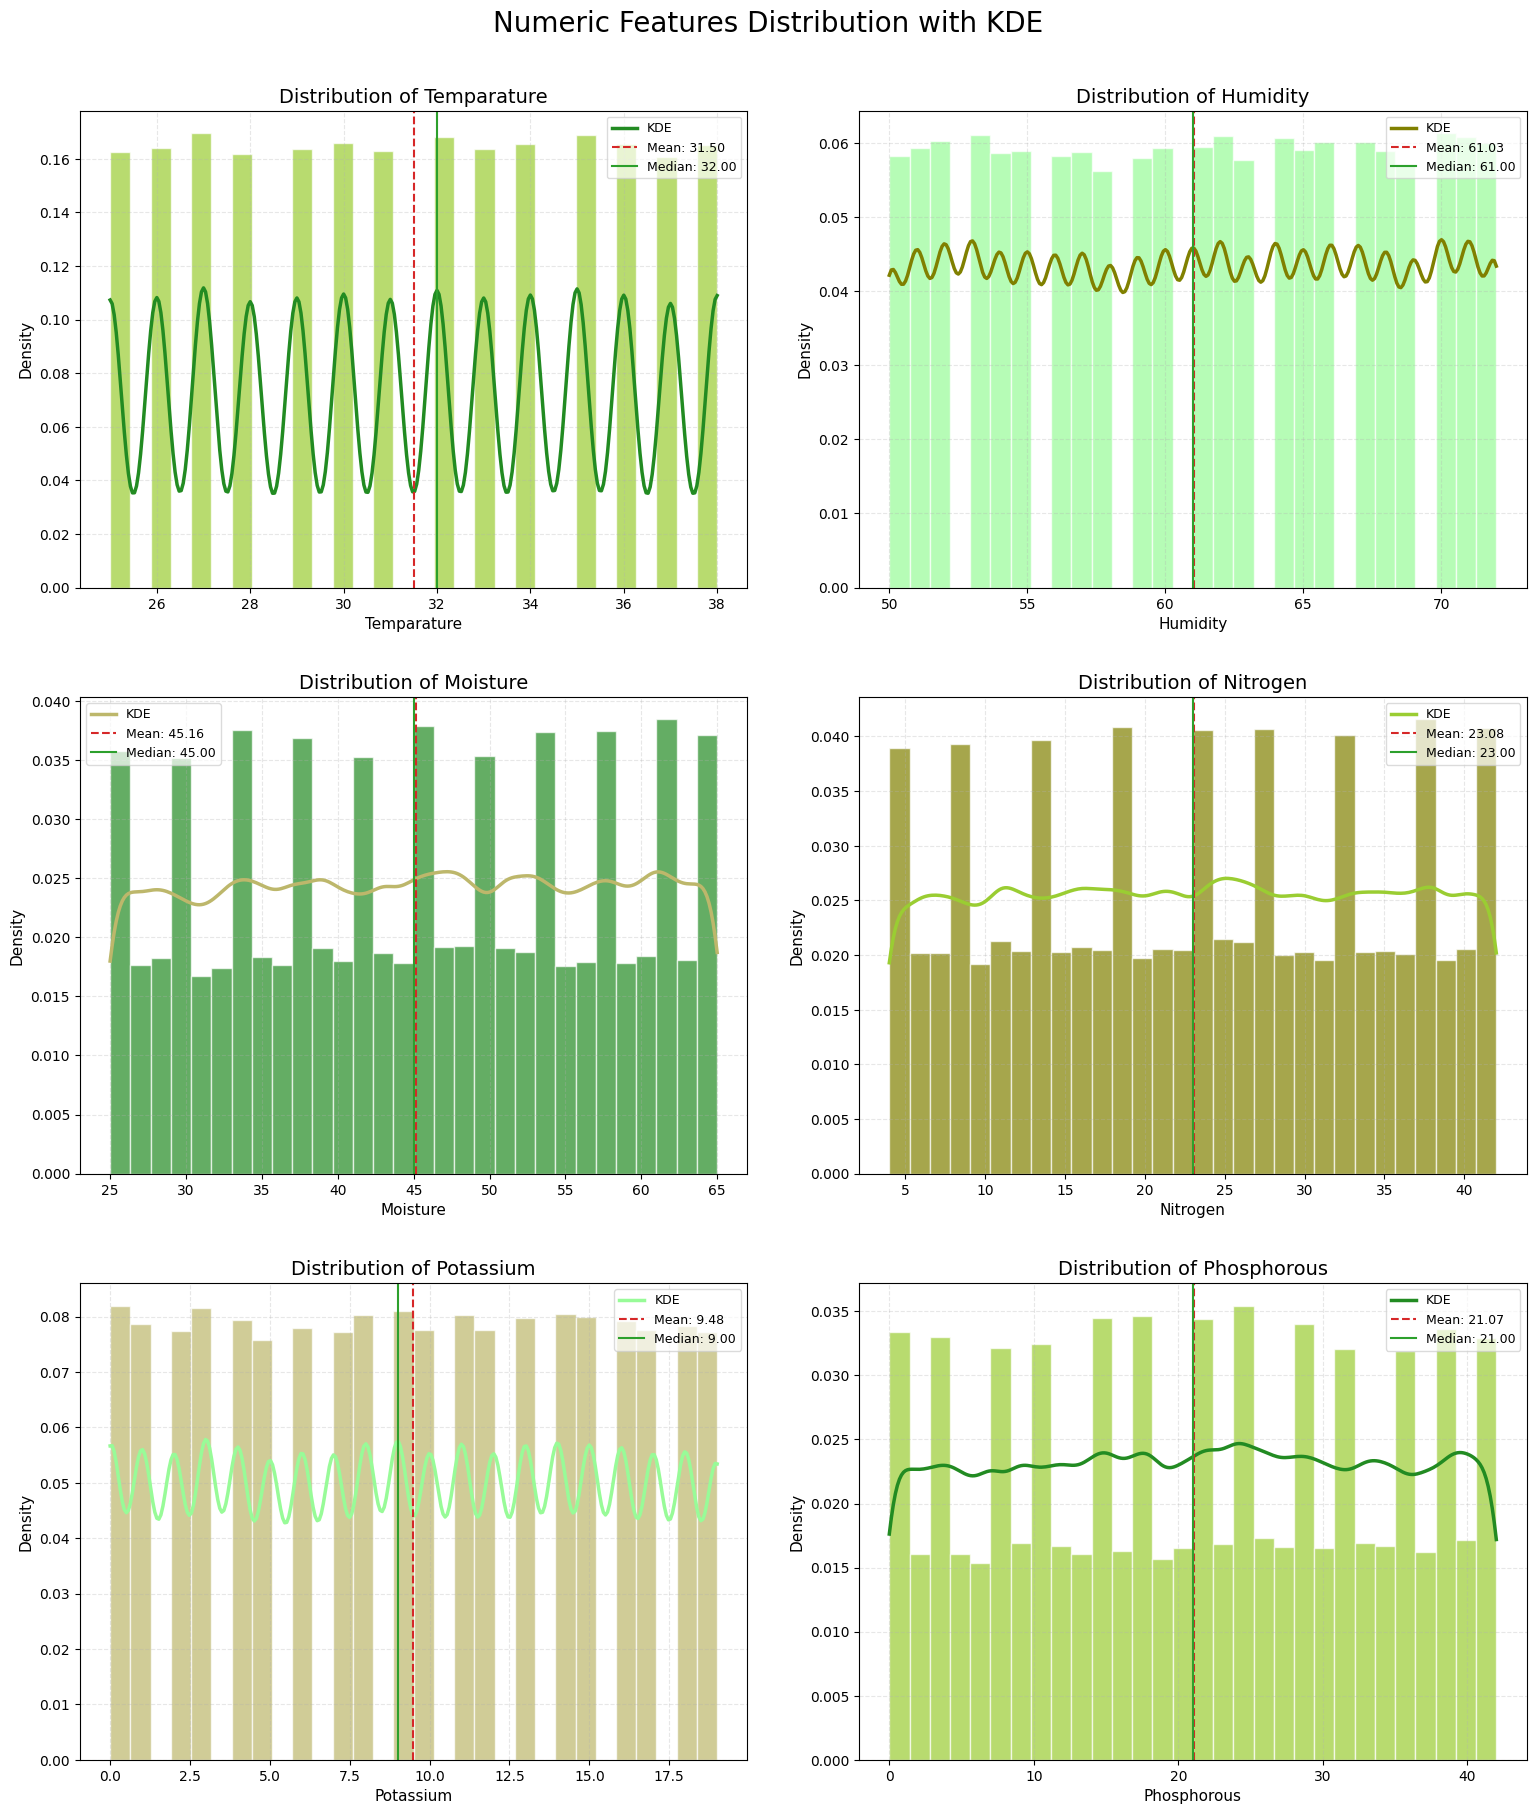

In [12]:
numeric_cols = train.select_dtypes(include=['int64', 'float64']).columns
if 'id' in numeric_cols:
    numeric_cols = numeric_cols.drop('id')

n_cols = 2
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, 6*n_rows))
axes = axes.flatten() 

grid_style = dict(alpha=0.3, linestyle='--', linewidth=0.8)

for i, col in enumerate(numeric_cols):
    # Get data
    data = train[col].dropna()
    
    # Create histogram with custom palette color
    hist_color = palette[i % len(palette)]
    n, bins, patches = axes[i].hist(data, 
                                   bins=30, 
                                   color=hist_color,
                                   alpha=0.7,
                                   edgecolor='white',
                                   density=True)  # Use density for KDE
    
    # Add KDE line with complementary color
    kde_color = palette[(i + 2) % len(palette)]  # Skip adjacent color
    kde = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 300)
    axes[i].plot(x_vals, kde(x_vals), color=kde_color, linewidth=2.5, label='KDE')
    
    # Add statistical annotations
    mean_val = data.mean()
    median_val = data.median()
    axes[i].axvline(mean_val, color='#d62728', linestyle='--', linewidth=1.5, label=f'Mean: {mean_val:.2f}')
    axes[i].axvline(median_val, color='#2ca02c', linestyle='-', linewidth=1.5, label=f'Median: {median_val:.2f}')
    
    # Titles and labels
    axes[i].set_title(f'Distribution of {col}', fontsize=14)
    axes[i].set_xlabel(col, fontsize=11)
    axes[i].set_ylabel('Density', fontsize=11)
    axes[i].grid(**grid_style)
    axes[i].legend(fontsize=9, framealpha=0.7)

# Hide unused subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout(pad=3.0)
plt.suptitle('Numeric Features Distribution with KDE', fontsize=20, y=1.02)
plt.show()

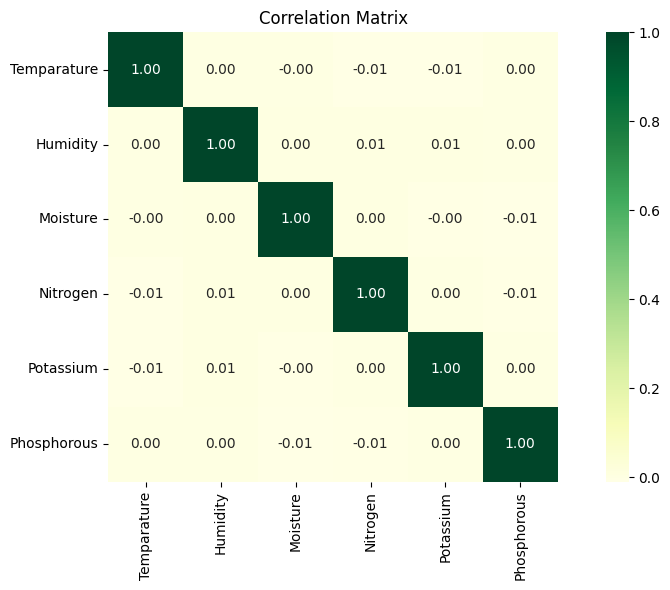

In [13]:
#Correlation heatmap (Numeric features)
corr = train[numeric_cols].corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='YlGn', square=True,
            xticklabels=numeric_cols, yticklabels=numeric_cols, cbar=True)

plt.title('Correlation Matrix')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [14]:
mean_nutrients = (train.groupby("Fertilizer Name")[["Nitrogen", "Potassium", "Phosphorous"]]
                   .mean().reset_index())
mean_nutrients

,Fertilizer Name,Nitrogen,Potassium,Phosphorous
0,10-26-26,23.188056,9.549425,20.979324
1,14-35-14,23.070559,9.483223,21.392568
2,17-17-17,23.184466,9.521651,21.046342
3,20-20,23.004350,9.584033,21.096250
4,28-28,23.004538,9.477056,21.020289
5,DAP,23.146966,9.267602,20.954162
6,Urea,22.956049,9.422573,20.933019


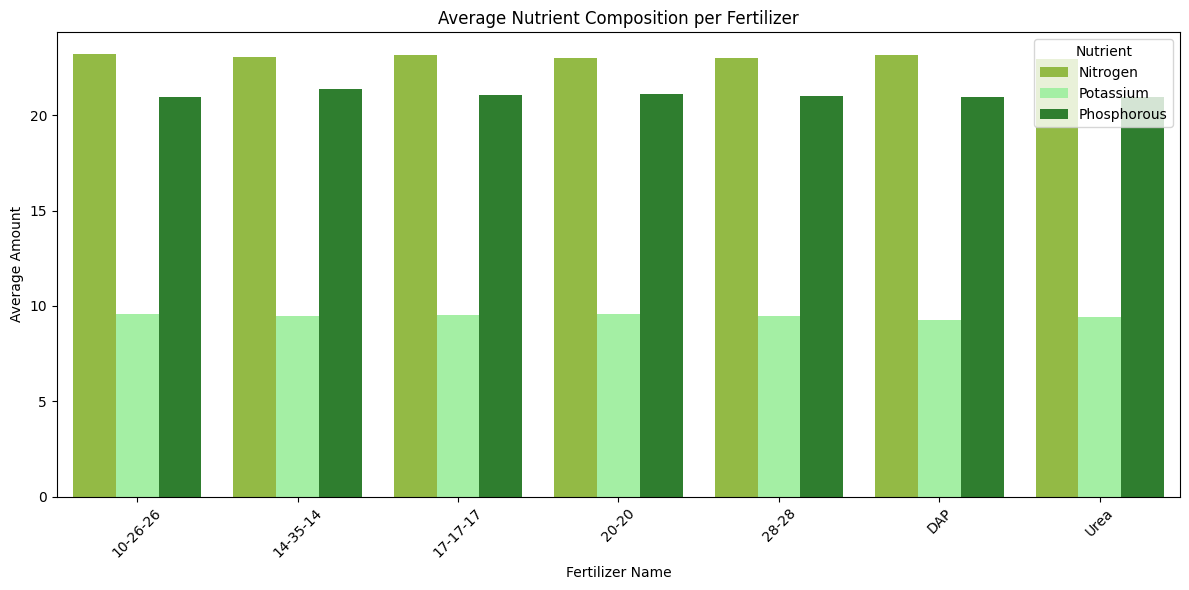

In [15]:
melted = mean_nutrients.melt(
    id_vars='Fertilizer Name', 
    value_vars=['Nitrogen', 'Potassium', 'Phosphorous'], 
    var_name='Nutrient', 
    value_name='Average Amount'
)


plt.figure(figsize=(12, 6))
sns.barplot(
    data=melted, 
    x='Fertilizer Name', 
    y='Average Amount', 
    hue='Nutrient',
    palette=palette
)
plt.title("Average Nutrient Composition per Fertilizer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

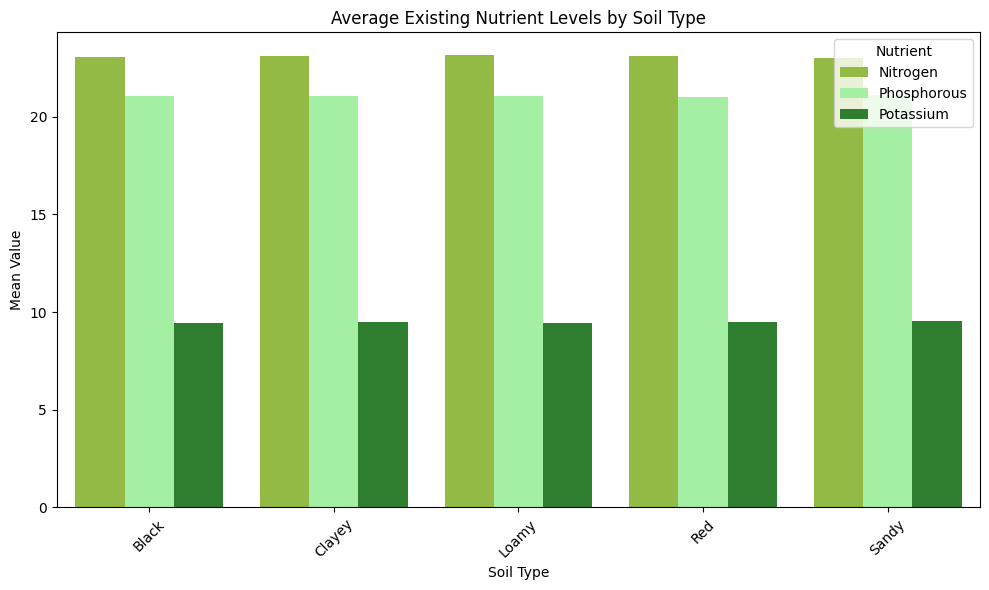

In [16]:
nutrient_means_by_soil = train.groupby("Soil Type")[["Nitrogen", "Phosphorous", "Potassium"]].mean().reset_index()

# Transform to long format for plotting
df_melted = nutrient_means_by_soil.melt(
    id_vars="Soil Type",
    value_vars=["Nitrogen", "Phosphorous", "Potassium"],
    var_name="Nutrient",
    value_name="Average Level"
)


plt.figure(figsize=(10, 6))
sns.barplot(
    data=df_melted,
    x="Soil Type",
    y="Average Level",
    hue="Nutrient",
    palette = palette
)
plt.title("Average Existing Nutrient Levels by Soil Type")
plt.xticks(rotation=45)
plt.ylabel("Mean Value")
plt.xlabel("Soil Type")
plt.tight_layout()
plt.show()

In [17]:
nutrient_means_by_soil = train.groupby("Soil Type")[["Nitrogen", "Phosphorous", "Potassium"]].mean().reset_index()
nutrient_means_by_soil

,Soil Type,Nitrogen,Phosphorous,Potassium
0,Black,23.038648,21.085329,9.414648
1,Clayey,23.092952,21.074854,9.501117
2,Loamy,23.160930,21.064034,9.460105
3,Red,23.098870,21.015790,9.487957
4,Sandy,23.019664,21.089385,9.522605


In [18]:
train.groupby(["Soil Type","Crop Type","Fertilizer Name"])[["Nitrogen","Phosphorous","Potassium"]].mean()

Nitrogen  Phosphorous  Potassium
Soil Type Crop Type Fertilizer Name                                   
Black     Barley    10-26-26         23.753890    21.514851   9.806695
                    14-35-14         23.018745    21.051345   9.753056
                    17-17-17         23.722923    20.958678   9.747716
                    20-20            23.144304    20.948354   9.489114
                    28-28            23.243633    21.187410   9.549255
...                                        ...          ...        ...
Sandy     Wheat     17-17-17         22.828696    21.914783   9.286522
                    20-20            23.261404    20.684649   9.542982
                    28-28            23.353047    20.633961   9.463262
                    DAP              22.846851    20.865491   9.258942
                    Urea             23.372760    20.681004   9.529954

[385 rows x 3 columns]

In [19]:
ct = train.groupby(["Soil Type", "Crop Type", "Fertilizer Name"]).size().unstack(fill_value=0)
ct

Fertilizer Name        10-26-26  14-35-14  17-17-17  20-20  28-28   DAP  Urea
Soil Type Crop Type                                                          
Black     Barley           2121      2454      2299   1975   2081  2027  2136
          Cotton           2262      2166      2106   2198   1876  2237  1961
          Ground Nuts      2069      2299      2243   2143   2165  1750  1667
          Maize            2237      2203      2094   1898   2066  2113  1980
          Millets          2197      2469      2077   2079   2138  2145  2004
          Oil seeds        2094      2322      1726   2019   1956  1755  1790
          Paddy            3129      2982      3111   2646   2978  2960  2482
          Pulses           2677      2907      2737   2612   2355  2135  1699
          Sugarcane        2542      2397      2445   2461   2333  1859  1667
          Tobacco          2278      2196      2178   2185   2091  2381  1847
          Wheat            2400      2243      2137   2328   1931  2058  2092
Clayey    Barley           2384      2055      2132   2127   2203  1476  1761
          Cotton           2406      2167      2404   2523   2447  2113  2041
          Ground Nuts      2106      2100      2016   1952   2178  1596  1426
          Maize            2147      2366      1927   2147   2207  1690  1943
          Millets          2180      2266      2171   2143   2459  1546  1961
          Oil seeds        2305      2141      2049   2099   2298  1688  1756
          Paddy            2771      2700      2805   2487   2776  2361  2108
          Pulses           2990      2838      3331   2835   2375  1695  1899
          Sugarcane        2263      2407      2293   2391   2254  1561  1431
          Tobacco          2620      2154      2293   2183   2300  2210  1808
          Wheat            2337      1887      2177   2463   2148  2120  1929
Loamy     Barley           2324      2356      2413   2173   2196  1789  1874
          Cotton           2222      2106      2359   2061   2135  2060  2033
          Ground Nuts      2104      2209      2005   2048   2128  1660  1478
          Maize            2272      2045      1997   1959   1850  1686  1643
          Millets          1926      2225      2161   2324   2131  1659  1798
          Oil seeds        2291      2323      2267   2171   2285  1775  1740
          Paddy            2948      2698      2766   2743   2920  2423  2221
          Pulses           2571      2814      2756   2816   2201  1717  1682
          Sugarcane        2357      2315      2140   2314   2213  1381  1391
          Tobacco          2285      2315      2094   2171   2178  2244  2188
          Wheat            2384      2063      2093   2197   2087  1991  1911
Red       Barley           1804      2073      2036   2170   2095  1955  1883
          Cotton           2247      2438      2147   2224   2350  2118  2284
          Ground Nuts      1975      2109      2183   2169   2089  1433  1736
          Maize            2314      1967      1972   1809   2112  1825  1980
          Millets          2106      2387      2178   2173   2293  1999  2081
          Oil seeds        2121      2118      2088   2300   2357  2197  1876
          Paddy            2756      2839      2733   2340   2809  2437  2573
          Pulses           2699      2984      2861   2627   2300  1897  2009
          Sugarcane        2213      2153      2114   2237   2044  1626  1569
          Tobacco          2249      2421      2423   2130   2094  2083  1886
          Wheat            2054      2197      2262   2258   1985  2288  2098
Sandy     Barley           2099      2189      2361   2332   2392  2040  2301
          Cotton           2405      2393      2651   2310   2358  2223  2377
          Ground Nuts      2069      2155      2262   2257   2452  1631  1928
          Maize            2162      2258      1964   2020   2279  2289  2161
          Millets          2177      2134      2184   2113   2221  2050  2290
          Oil seeds   

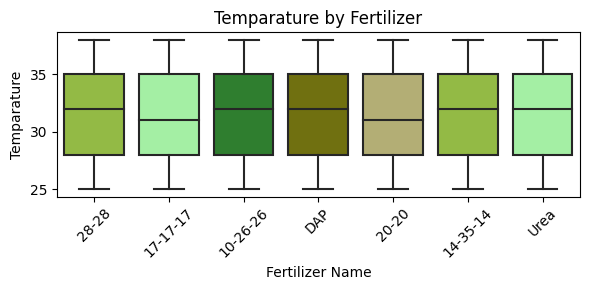

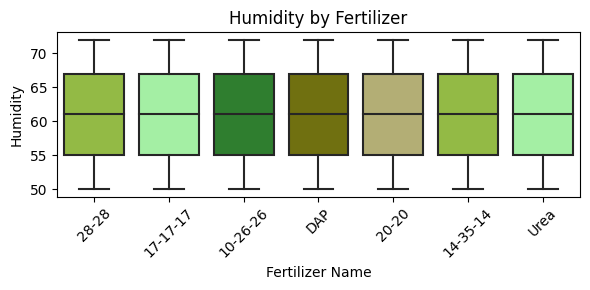

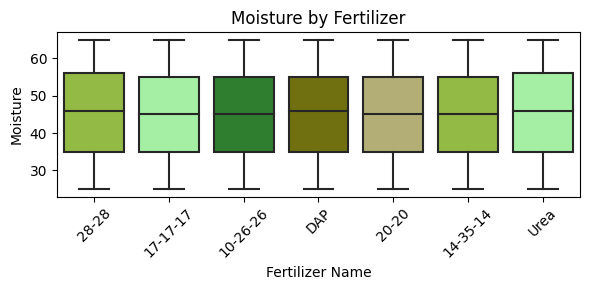

In [20]:
for col in ["Temparature", "Humidity", "Moisture"]:
    plt.figure(figsize=(6,3))
    sns.boxplot(data=train, x="Fertilizer Name", y=col, palette=palette)
    plt.xticks(rotation=45)
    plt.title(f"{col} by Fertilizer")
    plt.tight_layout()
    plt.show()

In [21]:
fert_c = pd.crosstab(train["Crop Type"], train["Fertilizer Name"], normalize="index")
fert_c

Fertilizer Name,10-26-26,14-35-14,17-17-17,20-20,28-28,DAP,Urea
Crop Type,,,,,,,
Barley,0.144859,0.150190,0.151729,0.145466,0.148031,0.125354,0.134371
Cotton,0.147204,0.143735,0.148799,0.144322,0.142409,0.137116,0.136415
Ground Nuts,0.147915,0.155782,0.153446,0.151440,0.157788,0.115633,0.117997
Maize,0.155514,0.151421,0.139057,0.137367,0.146881,0.134154,0.135607
Millets,0.142199,0.154221,0.144684,0.145503,0.151011,0.126254,0.136127
Oil seeds,0.152238,0.155349,0.140611,0.147434,0.153343,0.128644,0.122380
Paddy,0.148972,0.147116,0.147253,0.135077,0.153884,0.138841,0.128857
Pulses,0.153154,0.165394,0.165819,0.158862,0.137258,0.110679,0.108834
Sugarcane,0.159568,0.160044,0.153680,0.158861,0.152578,0.111796,0.103473


<a id="1"></a>
# <p style="background-color:#23a118;font-family:georgia,serif;color:#FFF8ED;font-size:120%;text-align:center;border-radius:10px 10px;">Preprocessing & Models</p>

---

* The data has low cardinality, so i'm going to encode them with label encoder.
* I am going to use XGBoost with an MAP3 function.

In [22]:
#Custom MAP@3 implementation
def mapk(y_true, y_pred, k=3):
    """
    Compute MAP@k for single-label ground truths.
    y_true: list of lists, each inner list contains the single true label index.
    y_pred: list of lists, each inner list contains k predicted label indices.
    """
    N = len(y_true)
    scores = []
    for true, preds in zip(y_true, y_pred):
        score = 0.0
        found = False
        for i, p in enumerate(preds[:k], start=1):
            if p in true and not found:
                score = 1.0 / i
                found = True
                break
        scores.append(score)
    return np.mean(scores)

#### FE combinations do not increase performance at all!

In [23]:
def create_features(df):
    
    # Calc mean for each numerical feature
    #means = df[numeric_cols].mean()
    
    #for feature in numeric_cols:
        # Squared difference from mean
        #df[f'{feature}_mean_sq_diff'] = (df[feature] - means[feature]) ** 2
        
        # Absolute difference from mean
        #df[f'{feature}_mean_abs_diff'] = (df[feature] - means[feature]).abs()
    
    #square and square root features
    #for feature in numeric_cols:
        #df[f'{feature}_sq'] = df[feature] ** 2
        #df[f'{feature}_sqrt'] = np.sqrt(df[feature])
    
    # Calculate Euclidean distance from mean vector
    #df['euclidean_dist'] = np.sqrt(
        #df['Temparature_mean_sq_diff'] +
        #df['Humidity_mean_sq_diff'] +
        #df['Moisture_mean_sq_diff'] +
        #df['Nitrogen_mean_sq_diff'] +
        #df['Potassium_mean_sq_diff'] +
        #df['Phosphorous_mean_sq_diff']
    #)
    
    return df

# Apply feature engineering to train and test datasets
#train = create_features(train)
#test = create_features(test)

In [24]:
cat_cols= ['Soil Type', 'Crop Type']
feature_encoders = {}
for col in cat_cols:
    le = LabelEncoder()
    train[col] = le.fit_transform(train[col])
    test[col] = le.transform(test[col])
    feature_encoders[col] = le

# encode the target column
target_encoder = LabelEncoder()
train['target_encoded'] = target_encoder.fit_transform(train['Fertilizer Name'])

In [25]:
"""
columns_to_encode = ['Temparature', 'Humidity', 'Moisture', 'Soil Type', 'Crop Type',
       'Nitrogen', 'Potassium', 'Phosphorous']



pair_size = [2, 3, 4]

for r in pair_size: 
    combinations_list = list(combinations(columns_to_encode,r))
    batch_size = 20
    
    for i in range(0, len(combinations_list), batch_size):
        batch = combinations_list[i:i+batch_size]
        for cols in tqdm(batch):
            new_col_name = '_'.join(cols)

            train[new_col_name] = train[list(cols)].astype(str).agg('_'.join, axis=1) 
            train[new_col_name] = train[new_col_name].astype('category')

            test[new_col_name] = test[list(cols)].astype(str).agg('_'.join, axis=1) 
            test[new_col_name] = test[new_col_name].astype('category')
        gc.collect()
        print(f"Memory usage: {train.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")
        print(f"Total number of columns: {len(train.columns)}")
"""

'\ncolumns_to_encode = [\'Temparature\', \'Humidity\', \'Moisture\', \'Soil Type\', \'Crop Type\',\n       \'Nitrogen\', \'Potassium\', \'Phosphorous\']\n\n\n\npair_size = [2, 3, 4]\n\nfor r in pair_size: \n    combinations_list = list(combinations(columns_to_encode,r))\n    batch_size = 20\n    \n    for i in range(0, len(combinations_list), batch_size):\n        batch = combinations_list[i:i+batch_size]\n        for cols in tqdm(batch):\n            new_col_name = \'_\'.join(cols)\n\n            train[new_col_name] = train[list(cols)].astype(str).agg(\'_\'.join, axis=1) \n            train[new_col_name] = train[new_col_name].astype(\'category\')\n\n            test[new_col_name] = test[list(cols)].astype(str).agg(\'_\'.join, axis=1) \n            test[new_col_name] = test[new_col_name].astype(\'category\')\n        gc.collect()\n        print(f"Memory usage: {train.memory_usage(deep=True).sum() / (1024*1024):.2f} MB")\n        print(f"Total number of columns: {len(train.columns)}")\n

In [26]:
features = [
    'Temparature',
    'Humidity',
    'Moisture',
    'Nitrogen',
    'Potassium',
    'Phosphorous',
    'Soil Type',
    'Crop Type'
]
X = train.drop(columns=['id', 'Fertilizer Name', 'target_encoded'])                
y = train['target_encoded'].values       

X_test  = test.drop(columns=["id"]).copy()    

In [27]:
#cross-validation with XGBoost

def map3_scorer(y_true, y_pred_probs):
    """
    y_true: array‐like of shape (n_samples,)
    y_pred_probs: array of shape (n_samples, n_classes)
    Returns MAP@3.
    """
    y_true_wrapped = [[int(lbl)] for lbl in y_true]
    top3 = np.argsort(-y_pred_probs, axis=1)[:, :3].tolist()
    return mapk(y_true_wrapped, top3, 3)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
map3_scores = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X, y), start=1):
    X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    model = xgb.XGBClassifier(
    max_depth=12,
    colsample_bytree=0.467,
    subsample=0.86,
    n_estimators=4000,
    learning_rate=0.03,
    gamma=0.26,
    max_delta_step=4,
    reg_alpha=2.7,
    reg_lambda=1.4,
    early_stopping_rounds=100,
    objective='multi:softprob',
    random_state=13,
    enable_categorical=True,
    tree_method='hist',
    device = "cuda"
    )
    
    model.fit(
        X_train, 
        y_train,  
        eval_set=[(X_val, y_val)], 
        verbose=False
    )
    
    val_probs = model.predict_proba(X_val)
    score = map3_scorer(y_val, val_probs)
    map3_scores.append(score)
    print(f"Fold {fold} MAP@3: {score:.4f}")

print(f"\nMean MAP@3 across 5 folds: {np.mean(map3_scores):.4f}")

Fold 1 MAP@3: 0.3677
Fold 2 MAP@3: 0.3672
Fold 3 MAP@3: 0.3681
Fold 4 MAP@3: 0.3672
Fold 5 MAP@3: 0.3665

Mean MAP@3 across 5 folds: 0.3673


In [28]:
# Train final model & predict on test

model_xgb = xgb.XGBClassifier(
    max_depth=12,
    colsample_bytree=0.467,
    subsample=0.86,
    n_estimators=4000,
    learning_rate=0.03,
    gamma=0.26,
    max_delta_step=4,
    reg_alpha=2.7,
    reg_lambda=1.4,
    objective='multi:softprob',
    num_class=len(le.classes_),
    eval_metric='mlogloss',
    use_label_encoder=False,
    random_state=13,
    tree_method='hist',
    device = "cuda"
)
model_xgb.fit(X, y)
xgb_probs = model_xgb.predict_proba(X_test)

In [29]:
top3_idx = np.argsort(xgb_probs, axis=1)[:, -3:][:, ::-1]
flat = top3_idx.flatten()
names_flat = target_encoder.inverse_transform(flat)
top3_names = names_flat.reshape(top3_idx.shape) 

predictions = [" ".join(row) for row in top3_names]

In [30]:
# Create submission DataFrame
submission = pd.DataFrame({
    'id': test['id'],
    'Fertilizer Name': predictions
})
submission.to_csv('submission.csv', index=False)
print("\n'submission.csv' has been created.")


'submission.csv' has been created.
